# WeatherPy

**Contents:**
1. [Random City Generation](#rng): Generates a random list of unique cities.

*Part 1: Making Plots*

2. [Data Retrieval](#get_data): Gets weather data for the randomly generated cities and throws them all into a Pandas Dataframe

3. [Scatter Plot Generation](#scatter): As the subheader suggests, we make charts here so we can do math on them later. The four charts generated compare a city's latitude to its temperature, humidity, cloudiness, and wind speed.

*Part 2: Doing Linear Regression*

4. [Setup](#regress): A linear regression function is defined and the data is split off into Northern and Southern Hemispheres. Personally, I think we could simply take the absolute value of all the Latitudes, but this is fine.

5. Charts: Each of these subsections has a chart for each of the hemispheres and a short analysis section at the end to explain the significance of the numbers.
    - [Latitude vs Temperature](#LatVTemp)
    - [Latitude vs Humidity](#LatVHum)
    - [Latitude vs Cloudiness](#LatVCloud)
    - [Latitude vs Wind Speed](#LatVWind)

---

In [32]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import json
from scipy.stats import linregress

# Import the OpenWeatherMap API key
from api_keys import weather_api_key

# Import citipy to determine the cities based on latitude and longitude
from citipy import citipy

<a id='rng'></a>
### Generate the Cities List by Using the `citipy` Library

In [22]:
# Starter Code given by the Berkeley Data Bootcamp. I'll just include comments here to show that I fully understand what's going on.
# Initializes an empty list for holding the latitude and longitude combos
lat_lngs = []

# Initializes an empty list for holding the cities names
cities = []

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Create a set of 1,500 random lat and lng combinations based on the ranges given in the tuples above
# First item of the tuple is the lower bound (inclusive) and the second item is the upper bound (inclusive) for random number generation
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)

# Packages up the previous randomly generated numbers into 1,500 pairs of latitude/longitude coordinates in the form of tuples in a zip object
lat_lngs = zip(lats, lngs)
# Note, don't touch the Zip. Strangely enough, it's consumable code. Calling print(list(lat_lngs)) for example makes the code on the bottom unusable for some reason
# Given that lats and lngs are both the same length, we could've just used a for i in range(len(lats)) loop, but I guess this looks cooler

# Identify nearest city for each lat, lng combination. We'll use Winston Tan's library here to quickly generate the closest cities to each coordinate.
# It doesn't seem as if there's a maximum range, so it'll generate a city (with a population of over 5,000 people as per the documentation of the library) even if you're out in the middle of the ocean.
# Basically, 1,500 cities are guaranteed to be generated, though there may be overlaps with multiple coordinate points being closest to the same city.

for lat_lng in lat_lngs: # Looping through both lats and lngs lists at the same time, generate city names
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
print(f"Number of cities in the list: {len(cities)}")

Number of cities in the list: 591


I tried running these sets of random city generations 1000 times and we can expect a median and average of about 600 unique places generated every time we run through this loop. There's a standard deviation of roughly 16.4 cities, so about 95% of the 1000 city generations had between 567 to 632 cities.

---

<a id='get_data'></a>
## Part 1: Create Plots to Showcase the Relationship Between Weather Variables and Latitude

### Using the OpenWeatherMap API to retrieve weather data from the list of generated cities

In [33]:
# Similarly, a lot of the skeleton code has already been provided. I'll annotate as usual to explain the implementation
# Set the API base URL. We'll iteratively change the parameters as needed
root_url = "https://api.openweathermap.org/data/2.5/weather?"

# Define an empty list to fetch the weather data for each city
# This will become a list of dictionaries to be converted into a Pandas dataframe
city_data = []

# Print to console
print("Beginning Data Retrieval     ")
print("-----------------------------")

# Create counters for grouping
record_count = 1
set_count = 1

# Loop through all the cities in our list to fetch weather data
# We do this for a convenient way of grouping chunks of data by some numerical interval
# Enumerate basically turns each entry in a list into tuples with (their_index, their_value) in them
for i, city in enumerate(cities): # i is the index, city is the value in that enumerated list
    
    # We'll use the index for convenient grouping for debugging
    # Group cities in sets of 50 for logging purposes
    if (i % 50 == 0 and i >= 50):
        set_count += 1 # Move onto a new set
        record_count = 1 # Reset count every time there's a new set

    # Create endpoint URL with each city
    city_url = f"{root_url}q={city}&units=metric&appid={weather_api_key}"
    
    # Log the url, record, and set numbers
    # We'll use Python String Interpolation here because that's how the skeleton code was written. I personally would've used f-strings, but hey it still works
    print("Processing Record %s of Set %s | %s" % (record_count, set_count, city))

    # Add 1 to the record count for record-keeping's sake
    record_count += 1

    # Run an API request for each of the cities
    # We do a try-except statement here because we can't guarantee OpenWeather has records on every city in the citipy's database
    try:
        # Get data into JSON form
        city_weather = requests.get(city_url).json()

        # Parse out latitude, longitude, max temp, humidity, cloudiness, wind speed, country, and date
        city_lat = city_weather["coord"]["lat"]
        city_lng = city_weather["coord"]["lon"]
        city_max_temp = city_weather["main"]["temp_max"]
        city_humidity = city_weather["main"]["humidity"]
        city_clouds = city_weather["clouds"]["all"]
        city_wind = city_weather["wind"]["speed"]
        city_country = city_weather["sys"]["country"]
        city_date = city_weather["dt"]
        
        # Append the City information into city_data list
        city_data.append({"City": city, 
                          "Lat": city_lat, 
                          "Lng": city_lng, 
                          "Max Temp": city_max_temp,
                          "Humidity": city_humidity,
                          "Cloudiness": city_clouds,
                          "Wind Speed": city_wind,
                          "Country": city_country,
                          "Date": city_date})

    # If an error is experienced, skip the city
    # Apparently an indiscriminate except is "bad practice", but considering how we're only expecting some kind of access error for places that don't exist, it should be fine. It's not production-quality anyways
    except:
        print(f"City({city}) not found. Skipping...")
        pass
              
# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")

Beginning Data Retrieval     
-----------------------------
Processing Record 1 of Set 1 | grytviken
Processing Record 2 of Set 1 | dudinka
Processing Record 3 of Set 1 | kourou
Processing Record 4 of Set 1 | atafu village
Processing Record 5 of Set 1 | port alfred
Processing Record 6 of Set 1 | georgetown
Processing Record 7 of Set 1 | port-aux-francais
Processing Record 8 of Set 1 | naze
Processing Record 9 of Set 1 | midleton
Processing Record 10 of Set 1 | kapuskasing
Processing Record 11 of Set 1 | ribeira grande
Processing Record 12 of Set 1 | margaret river
Processing Record 13 of Set 1 | hawaiian paradise park
Processing Record 14 of Set 1 | antalaha
Processing Record 15 of Set 1 | albany
Processing Record 16 of Set 1 | ta`u
Processing Record 17 of Set 1 | waitangi
Processing Record 18 of Set 1 | invercargill
Processing Record 19 of Set 1 | afaahiti
Processing Record 20 of Set 1 | san antonio de pale
Processing Record 21 of Set 1 | pacific grove
Processing Record 22 of Set 1 | 

Processing Record 41 of Set 4 | berezovyy
Processing Record 42 of Set 4 | taiohae
City(taiohae) not found. Skipping...
Processing Record 43 of Set 4 | tindouf
Processing Record 44 of Set 4 | kangiwa
Processing Record 45 of Set 4 | macia
Processing Record 46 of Set 4 | chinde
Processing Record 47 of Set 4 | tazacorte
Processing Record 48 of Set 4 | city of balikpapan
Processing Record 49 of Set 4 | al 'alamayn
City(al 'alamayn) not found. Skipping...
Processing Record 50 of Set 4 | san luis de la loma
Processing Record 1 of Set 5 | bardai
Processing Record 2 of Set 5 | hafar al-batin
Processing Record 3 of Set 5 | saint-joseph
Processing Record 4 of Set 5 | bousso
Processing Record 5 of Set 5 | kudahuvadhoo
Processing Record 6 of Set 5 | tocopilla
Processing Record 7 of Set 5 | omaruru
Processing Record 8 of Set 5 | goianapolis
Processing Record 9 of Set 5 | laojunmiao
Processing Record 10 of Set 5 | ternate
Processing Record 11 of Set 5 | candon
Processing Record 12 of Set 5 | qaqortoq

Processing Record 30 of Set 8 | villa gesell
Processing Record 31 of Set 8 | mount isa
Processing Record 32 of Set 8 | bonthe
Processing Record 33 of Set 8 | launceston
Processing Record 34 of Set 8 | yeppoon
Processing Record 35 of Set 8 | colby
Processing Record 36 of Set 8 | praya
Processing Record 37 of Set 8 | okhotsk
Processing Record 38 of Set 8 | ciudad bolivar
Processing Record 39 of Set 8 | lata
Processing Record 40 of Set 8 | gueltat zemmour
City(gueltat zemmour) not found. Skipping...
Processing Record 41 of Set 8 | louis trichardt
Processing Record 42 of Set 8 | tortoli
Processing Record 43 of Set 8 | nagqu
Processing Record 44 of Set 8 | rukban
City(rukban) not found. Skipping...
Processing Record 45 of Set 8 | hue
Processing Record 46 of Set 8 | cromwell
Processing Record 47 of Set 8 | aksu
Processing Record 48 of Set 8 | sinop
Processing Record 49 of Set 8 | ichalkaranji
Processing Record 50 of Set 8 | mil'kovo
Processing Record 1 of Set 9 | priyutovo
Processing Record 

Processing Record 16 of Set 12 | oranjemund
Processing Record 17 of Set 12 | dailekh
Processing Record 18 of Set 12 | sainte-suzanne
Processing Record 19 of Set 12 | pemba
Processing Record 20 of Set 12 | libreville
Processing Record 21 of Set 12 | touros
Processing Record 22 of Set 12 | constitucion
Processing Record 23 of Set 12 | kirkwall
Processing Record 24 of Set 12 | mundri
Processing Record 25 of Set 12 | truth or consequences
Processing Record 26 of Set 12 | pangody
Processing Record 27 of Set 12 | island harbour
Processing Record 28 of Set 12 | bezopasnoye
Processing Record 29 of Set 12 | yarmouth
Processing Record 30 of Set 12 | sergeyevka
Processing Record 31 of Set 12 | jwaneng
Processing Record 32 of Set 12 | san rafael del sur
Processing Record 33 of Set 12 | zangguy
City(zangguy) not found. Skipping...
Processing Record 34 of Set 12 | tsiombe
Processing Record 35 of Set 12 | myeik
Processing Record 36 of Set 12 | cestos city
Processing Record 37 of Set 12 | fangshan
Pro

In [41]:
# Convert the cities weather data into a Pandas DataFrame
city_data_df = pd.DataFrame(city_data)

# Show Record Count - We should expect most of our cities to have data
city_data_df.count()

City          563
Lat           563
Lng           563
Max Temp      563
Humidity      563
Cloudiness    563
Wind Speed    563
Country       563
Date          563
dtype: int64

In [42]:
# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,grytviken,-54.2811,-36.5092,0.45,59,97,1.76,GS,1684714996
1,dudinka,69.4058,86.1778,0.90,99,100,5.95,RU,1684714775
2,kourou,5.1552,-52.6478,25.03,93,100,4.08,GF,1684714776
3,atafu village,-8.5421,-172.5159,28.77,76,34,4.65,TK,1684714996
4,port alfred,-33.5906,26.8910,14.81,69,23,4.27,ZA,1684714997


In [43]:
# Export the City_Data into a csv
# This is just for testing result reproducibility. I'm going to be doing some chart stuff later on, so this is here for people to see if their results reasonably match up with mine
city_data_df.to_csv("output_data/cities.csv", index_label="City_ID")

In [44]:
# Read saved data
city_data_df = pd.read_csv("output_data/cities.csv", index_col="City_ID")

# Display sample data
city_data_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
0,grytviken,-54.2811,-36.5092,0.45,59,97,1.76,GS,1684714996
1,dudinka,69.4058,86.1778,0.90,99,100,5.95,RU,1684714775
2,kourou,5.1552,-52.6478,25.03,93,100,4.08,GF,1684714776
3,atafu village,-8.5421,-172.5159,28.77,76,34,4.65,TK,1684714996
4,port alfred,-33.5906,26.8910,14.81,69,23,4.27,ZA,1684714997


In [46]:
# Honestly, I just have this here so I can see if anything needs to be converted later on
city_data_df.dtypes

City           object
Lat           float64
Lng           float64
Max Temp      float64
Humidity        int64
Cloudiness      int64
Wind Speed    float64
Country        object
Date            int64
dtype: object

<a id='scatter'></a>
### Create the Scatter Plots Requested

#### Latitude Vs. Temperature

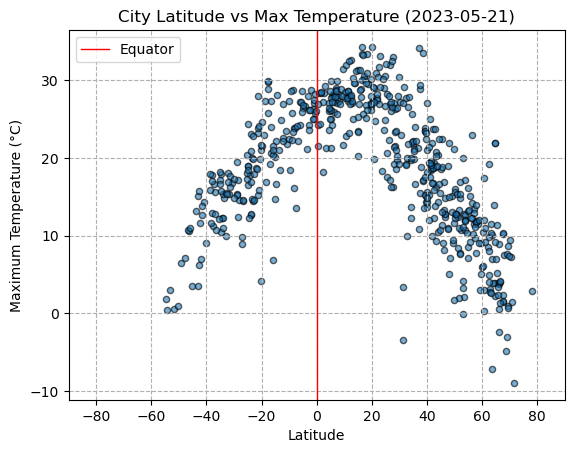

In [75]:
# Build scatter plot for Latitude vs. Temperature, customize properties as needed
city_data_df.plot(kind="scatter", x="Lat", y="Max Temp", \
                 xlabel="Latitude", ylabel="Maximum Temperature (°C)", title="City Latitude vs Max Temperature (2023-05-21)", \
                  grid=True, alpha=.6, edgecolors="black", linewidth=1)

# Other graph properties
plt.xlim(-90,90)
plt.axvline(0, color="red", linewidth=1, label="Equator")
plt.grid(linestyle="--")
plt.legend(loc="upper left")

# Save the figure
plt.savefig("output_data/Fig1.png")

# Show plot
plt.show()

Do not worry about how there aren't points between -90 to -60. The southernmost city in the world is in Chile at around 54 degrees South, so it's natural. It's just water, ice, and penguins to the south of that.

#### Latitude Vs. Humidity

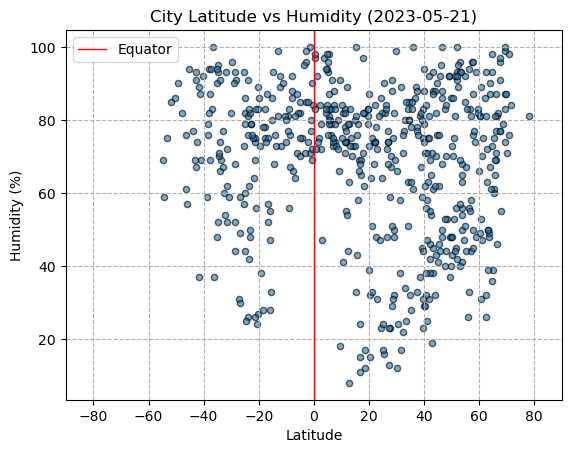

In [76]:
# Build scatter plot for Latitude vs. Humidity, customize properties as needed
city_data_df.plot(kind="scatter", x="Lat", y="Humidity", \
                 xlabel="Latitude", ylabel="Humidity (%)", title="City Latitude vs Humidity (2023-05-21)", \
                  grid=True, alpha=.6, edgecolors="black", linewidth=1)

# Other graph properties
plt.xlim(-90,90)
plt.axvline(0, color="red", linewidth=1, label="Equator")
plt.grid(linestyle="--")
plt.legend(loc="upper left")

# Save the figure
plt.savefig("output_data/Fig2.png")

# Show plot
plt.show()

#### Latitude Vs. Cloudiness

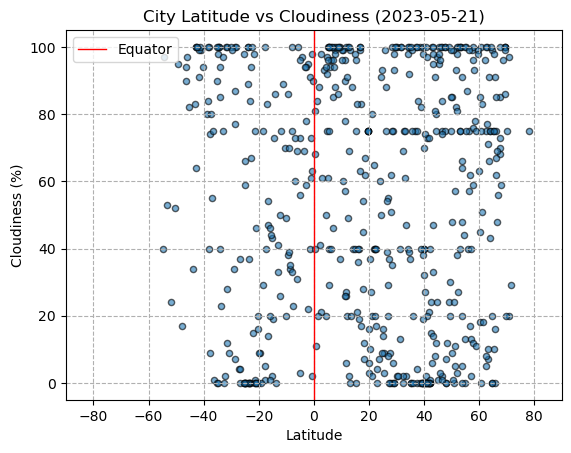

In [77]:
# Build scatter plot for Latitude vs. Cloudiness, customize properties as needed
city_data_df.plot(kind="scatter", x="Lat", y="Cloudiness", \
                 xlabel="Latitude", ylabel="Cloudiness (%)", title="City Latitude vs Cloudiness (2023-05-21)", \
                  grid=True, alpha=.6, edgecolors="black", linewidth=1)

# Other graph properties
plt.xlim(-90,90)
plt.axvline(0, color="red", linewidth=1, label="Equator")
plt.grid(linestyle="--")
plt.legend(loc="upper left")

# Save the figure
plt.savefig("output_data/Fig3.png")

# Show plot
plt.show()

#### Latitude vs. Wind Speed Plot

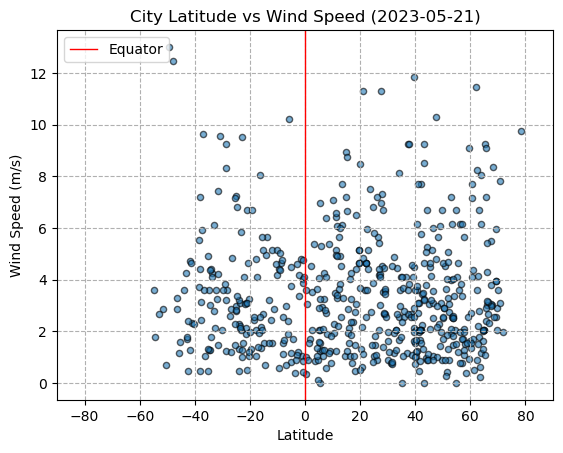

In [78]:
# Build scatter plot for Latitude vs. Wind Speed, customize properties as needed
city_data_df.plot(kind="scatter", x="Lat", y="Wind Speed", \
                 xlabel="Latitude", ylabel="Wind Speed (m/s)", title="City Latitude vs Wind Speed (2023-05-21)", \
                  grid=True, alpha=.6, edgecolors="black", linewidth=1)

# Other graph properties
plt.xlim(-90,90)
plt.axvline(0, color="red", linewidth=1, label="Equator")
plt.grid(linestyle="--")
plt.legend(loc="upper left")

# Save the figure
plt.savefig("output_data/Fig4.png")

# Show plot
plt.show()

You can already notice just from eyeballing the charts that, really, the only parameter here affected by latitude is the maximum temperature of each city.

---
<a id='regress'></a>
## Part 2: Compute Linear Regression for Each Relationship


In [91]:
# Define a function to create Linear Regression plots because this is a mouthful
# Takes in independent and dependent variables as series and spits back out a linear regression equation
# As we'll be needing Pearson-R stuff, it's in our best interest to use the more unruly SciPy method
def reg_this(x, y):
    result = linregress(x, y)
    
    # Access values with reg_this(x,y).slope, .intercept, .rvalue (Pearson-R), .pvalue (Hypothesis test for statistical significance of discovered regression), .stderr (Standard Error)
    return result

In [83]:
# Create a DataFrame with the Northern Hemisphere data (Latitude >= 0)
northern_hemi_df = city_data_df.loc[(city_data_df["Lat"]>=0)]

# Display sample data
northern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
1,dudinka,69.4058,86.1778,0.90,99,100,5.95,RU,1684714775
2,kourou,5.1552,-52.6478,25.03,93,100,4.08,GF,1684714776
5,georgetown,5.4112,100.3354,27.96,83,40,0.00,MY,1684714397
7,naze,28.3667,129.4833,21.51,91,100,3.53,JP,1684714997
8,midleton,51.9153,-8.1805,14.88,93,98,1.32,IE,1684714997


In [82]:
# Create a DataFrame with the Southern Hemisphere data (Latitude < 0)
southern_hemi_df = city_data_df.loc[(city_data_df["Lat"]<0)]

# Display sample data
southern_hemi_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
City_ID,,,,,,,,,
0,grytviken,-54.2811,-36.5092,0.45,59,97,1.76,GS,1684714996
3,atafu village,-8.5421,-172.5159,28.77,76,34,4.65,TK,1684714996
4,port alfred,-33.5906,26.8910,14.81,69,23,4.27,ZA,1684714997
6,port-aux-francais,-49.3500,70.2167,6.53,90,95,13.01,TF,1684714997
11,margaret river,-33.9500,115.0667,15.36,66,85,4.41,AU,1684714731


<a id='LatVTemp'></a>
### Latitude vs Temperature Linear Regression Plot

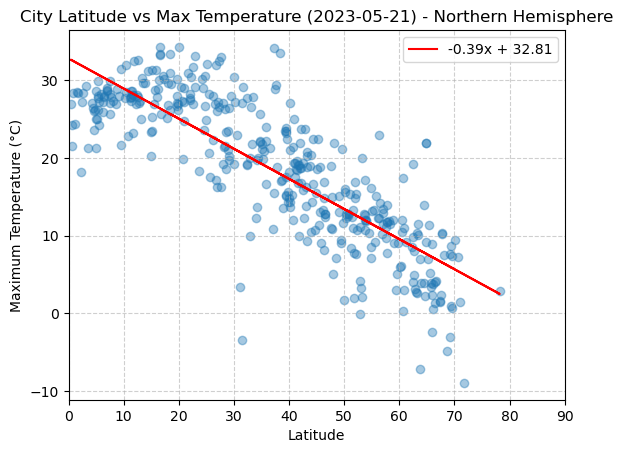

The r-value is -0.8304566099924672
The p-value is 3.772651181467679e-102
The standard error is 0.013090914759700738


In [104]:
# NORTH
# Call Regression Function here
X = northern_hemi_df["Lat"]
Y = northern_hemi_df["Max Temp"]
result = reg_this(X, Y)

# Get the appropriate scatter plot
# Some features reduced so it doesn't look as cluttered and the linear regression line can be accentuated.
plt.scatter(X, Y, alpha=.4)

# Other graph properties
plt.xlabel("Latitude")
plt.ylabel("Maximum Temperature (°C)")
plt.title("City Latitude vs Max Temperature (2023-05-21) - Northern Hemisphere")
plt.xlim(0,90)
plt.grid(linestyle="--", alpha = .6)

# Graph LinReg plot here
plt.plot(X, (result.slope*X+result.intercept), label=f"{result.slope:.2f}x + {result.intercept:.2f}", color = "red")

# Show plots
plt.legend(loc="best")
plt.show()
print(f"The r-value is {result.rvalue}")
print(f"The p-value is {result.pvalue}")
print(f"The standard error is {result.stderr}")

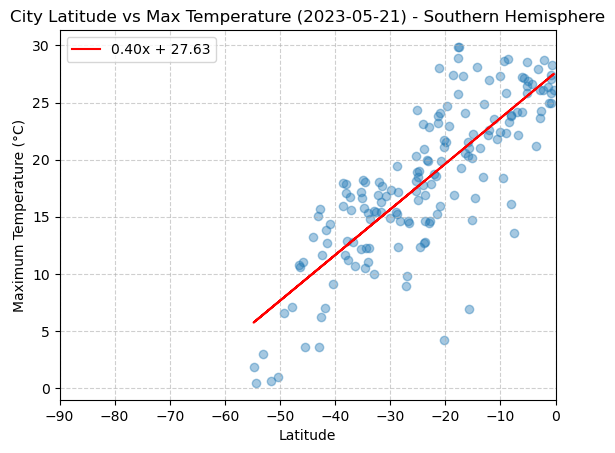

The r-value is 0.8098911419031551
The p-value is 4.537130708410472e-40
The standard error is 0.022530361300694957


In [105]:
# SOUTH
# Call Regression Function here
X = southern_hemi_df["Lat"]
Y = southern_hemi_df["Max Temp"]
result = reg_this(X, Y)

# Get the appropriate scatter plot
# Some features reduced so it doesn't look as cluttered and the linear regression line can be accentuated.
plt.scatter(X, Y, alpha=.4)

# Other graph properties
plt.xlabel("Latitude")
plt.ylabel("Maximum Temperature (°C)")
plt.title("City Latitude vs Max Temperature (2023-05-21) - Southern Hemisphere")
plt.xlim(-90,0)
plt.grid(linestyle="--", alpha = .6)

# Graph LinReg plot here
plt.plot(X, (result.slope*X+result.intercept), label=f"{result.slope:.2f}x + {result.intercept:.2f}", color = "red")

# Show plots
plt.legend(loc="best")
plt.show()
print(f"The r-value is {result.rvalue}")
print(f"The p-value is {result.pvalue}")
print(f"The standard error is {result.stderr}")

**Discussion about the linear relationship:** There exists a very strong (| r | > 0.8) negative and positive relationship between a city's latitude and maximum temperature in the Northern and Southern hemispheres, respectively. Naturally, the further you get from the equator, the colder it gets at about 0.4°C per degree towards the Earth's poles.

With a p-value that's significantly smaller than an alpha value of 0.05, we can safely and confidently reject the null hypothesis that there is *not* an association between changes to the predictor and changes to the dependent variable.

This makes sense. Though albedo, proximity to oceans, and all that other stuff can affect the temperature of a location, the primary factor determining the temperature of an area is the amount of direct sunlight a location absorbs. Due to how the Earth is angled, cities near the equator absorb more concentrated sunlight with radiation filtered by the least amount of atmosphere compared to cities closer to the poles. Sunlight is refracted more near the poles, so the surface there consequently receives less heat per fixed unit of area compared to that received near the equator.

<a id='LatVHum'></a>
### Latitude vs Humidity Linear Regression Plot

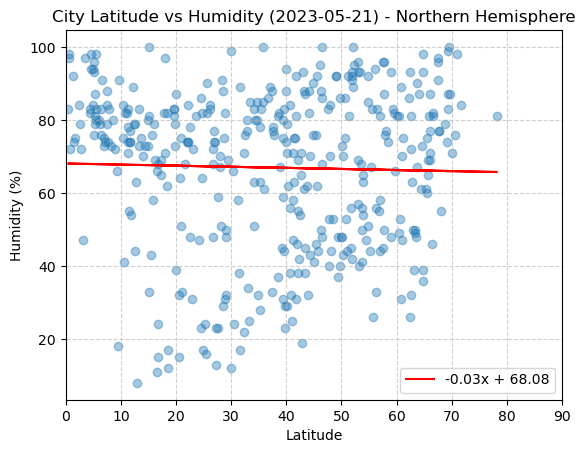

The r-value is -0.027034857025780408
The p-value is 0.5916930148110793
The standard error is 0.055544622172292606


In [106]:
# NORTH
# Call Regression Function here
X = northern_hemi_df["Lat"]
Y = northern_hemi_df["Humidity"]
result = reg_this(X, Y)

# Get the appropriate scatter plot
# Some features reduced so it doesn't look as cluttered and the linear regression line can be accentuated.
plt.scatter(X, Y, alpha=.4)

# Other graph properties
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title("City Latitude vs Humidity (2023-05-21) - Northern Hemisphere")
plt.xlim(0,90)
plt.grid(linestyle="--", alpha = .6)

# Graph LinReg plot here
plt.plot(X, (result.slope*X+result.intercept), label=f"{result.slope:.2f}x + {result.intercept:.2f}", color = "red")

# Show plots
plt.legend(loc="best")
plt.show()
print(f"The r-value is {result.rvalue}")
print(f"The p-value is {result.pvalue}")
print(f"The standard error is {result.stderr}")

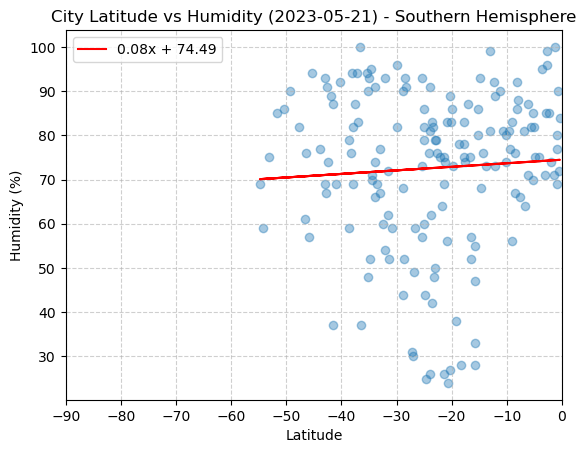

The r-value is 0.06098674845538342
The p-value is 0.4336669933106134
The standard error is 0.1023158147524528


In [108]:
# SOUTH
# Call Regression Function here
X = southern_hemi_df["Lat"]
Y = southern_hemi_df["Humidity"]
result = reg_this(X, Y)

# Get the appropriate scatter plot
# Some features reduced so it doesn't look as cluttered and the linear regression line can be accentuated.
plt.scatter(X, Y, alpha=.4)

# Other graph properties
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title("City Latitude vs Humidity (2023-05-21) - Southern Hemisphere")
plt.xlim(-90,0)
plt.grid(linestyle="--", alpha = .6)

# Graph LinReg plot here
plt.plot(X, (result.slope*X+result.intercept), label=f"{result.slope:.2f}x + {result.intercept:.2f}", color = "red")

# Show plots
plt.legend(loc="best")
plt.show()
print(f"The r-value is {result.rvalue}")
print(f"The p-value is {result.pvalue}")
print(f"The standard error is {result.stderr}")

**Discussion about the linear relationship:** In both the Northern and Southern hemispheres, the correlation between latitude and humidity is nearly non-existent (| r | ≈ 0) and a high p-value suggests we cannot confidently reject the null hypothesis that there is *no* association between change to the latitude and change to the humidity of a city.

This makes sense as humidity is defined to be the amount of water vapor in the air. It does not matter where you are, your humidity is going to be low if you aren't close to a large body of water and winds that will carry that airborne water over to your city. This is reinforced by the fact that we have deserts both far (e.g.: Australia's practically a big desert) and close (e.g.: Sahara desert) to the equator.

I'm no meteorologist, so there's probably something about dew points that I did not account for. However, based on the data, I can confidently assert there's practically no relation between a city's latitude and humidity.

<a id='LatVCloud'></a>
### Latitude vs Cloudiness Linear Regression Plot

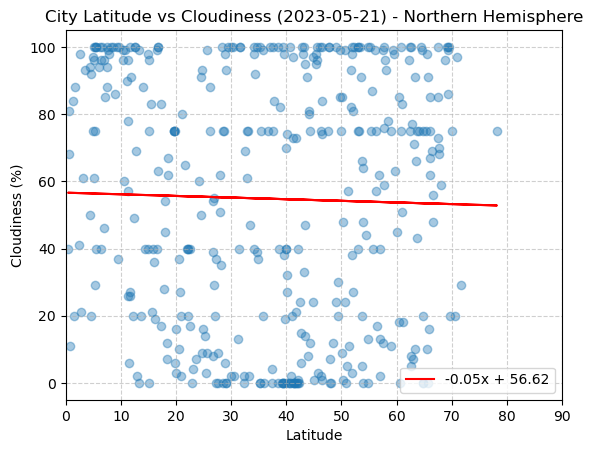

The r-value is -0.025886025576879856
The p-value is 0.6075435103997264
The standard error is 0.09452999536436352


In [109]:
# NORTH
# Call Regression Function here
X = northern_hemi_df["Lat"]
Y = northern_hemi_df["Cloudiness"]
result = reg_this(X, Y)

# Get the appropriate scatter plot
# Some features reduced so it doesn't look as cluttered and the linear regression line can be accentuated.
plt.scatter(X, Y, alpha=.4)

# Other graph properties
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title("City Latitude vs Cloudiness (2023-05-21) - Northern Hemisphere")
plt.xlim(0,90)
plt.grid(linestyle="--", alpha = .6)

# Graph LinReg plot here
plt.plot(X, (result.slope*X+result.intercept), label=f"{result.slope:.2f}x + {result.intercept:.2f}", color = "red")

# Show plots
plt.legend(loc="best")
plt.show()
print(f"The r-value is {result.rvalue}")
print(f"The p-value is {result.pvalue}")
print(f"The standard error is {result.stderr}")

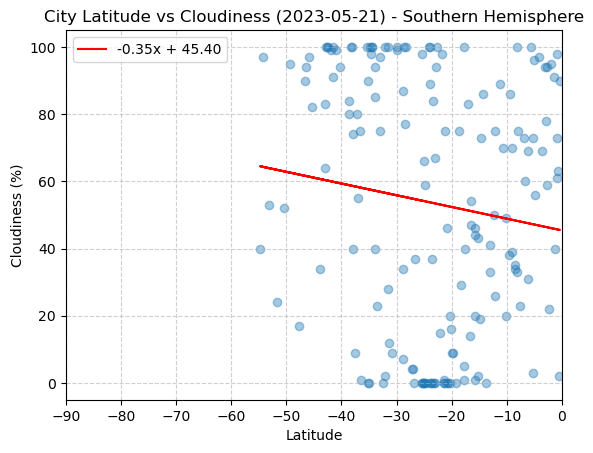

The r-value is -0.12711162969693776
The p-value is 0.10164019871955134
The standard error is 0.21177037797895298


In [110]:
# SOUTH
# Call Regression Function here
X = southern_hemi_df["Lat"]
Y = southern_hemi_df["Cloudiness"]
result = reg_this(X, Y)

# Get the appropriate scatter plot
# Some features reduced so it doesn't look as cluttered and the linear regression line can be accentuated.
plt.scatter(X, Y, alpha=.4)

# Other graph properties
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title("City Latitude vs Cloudiness (2023-05-21) - Southern Hemisphere")
plt.xlim(-90,0)
plt.grid(linestyle="--", alpha = .6)

# Graph LinReg plot here
plt.plot(X, (result.slope*X+result.intercept), label=f"{result.slope:.2f}x + {result.intercept:.2f}", color = "red")

# Show plots
plt.legend(loc="best")
plt.show()
print(f"The r-value is {result.rvalue}")
print(f"The p-value is {result.pvalue}")
print(f"The standard error is {result.stderr}")

**Discussion about the linear relationship:** Similar to the previous discussion regarding humidity, the correlation between latitude and cloudiness is tenuous at best (| r | < 0.15) and a higher than acceptable p-value suggests we cannot confidently reject the null hypothesis that there is *no* association between change to the latitude and change to the cloudiness of a city.

Following up the humidity analysis, you need water to make clouds and some other weather magic for the water droplets to condense. Since you need water to make clouds, the latitude of a city does not necessarily affect the production of clouds. Although the chart on the Southern hemisphere seems to suggest some kind of non-zero trend, I attribute that to noise in the data and how the final sample only has around 200 data points.

<a id='LatVWind'></a>
### Latitude vs Wind Speed Linear Regression Plot

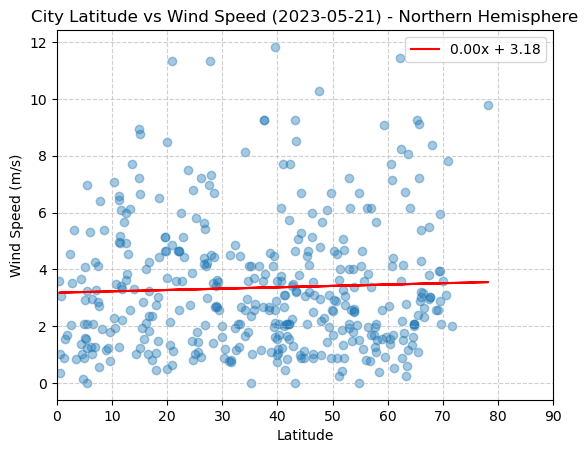

The r-value is 0.04133103425531598
The p-value is 0.4120862838776712
The standard error is 0.005807556400551741


In [111]:
# NORTH
# Call Regression Function here
X = northern_hemi_df["Lat"]
Y = northern_hemi_df["Wind Speed"]
result = reg_this(X, Y)

# Get the appropriate scatter plot
# Some features reduced so it doesn't look as cluttered and the linear regression line can be accentuated.
plt.scatter(X, Y, alpha=.4)

# Other graph properties
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (m/s)")
plt.title("City Latitude vs Wind Speed (2023-05-21) - Northern Hemisphere")
plt.xlim(0,90)
plt.grid(linestyle="--", alpha = .6)

# Graph LinReg plot here
plt.plot(X, (result.slope*X+result.intercept), label=f"{result.slope:.2f}x + {result.intercept:.2f}", color = "red")

# Show plots
plt.legend(loc="best")
plt.show()
print(f"The r-value is {result.rvalue}")
print(f"The p-value is {result.pvalue}")
print(f"The standard error is {result.stderr}")

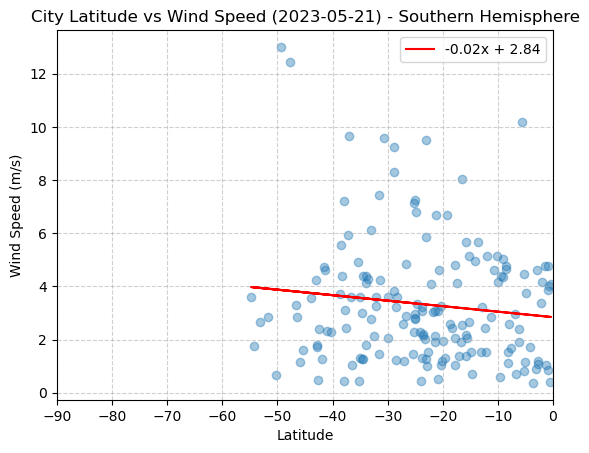

The r-value is -0.12210640664525299
The p-value is 0.11595083033714176
The standard error is 0.013092493701486288


In [113]:
# SOUTH
# Call Regression Function here
X = southern_hemi_df["Lat"]
Y = southern_hemi_df["Wind Speed"]
result = reg_this(X, Y)

# Get the appropriate scatter plot
# Some features reduced so it doesn't look as cluttered and the linear regression line can be accentuated.
plt.scatter(X, Y, alpha=.4)

# Other graph properties
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (m/s)")
plt.title("City Latitude vs Wind Speed (2023-05-21) - Southern Hemisphere")
plt.xlim(-90,0)
plt.grid(linestyle="--", alpha = .6)

# Graph LinReg plot here
plt.plot(X, (result.slope*X+result.intercept), label=f"{result.slope:.2f}x + {result.intercept:.2f}", color = "red")

# Show plots
plt.legend(loc="best")
plt.show()
print(f"The r-value is {result.rvalue}")
print(f"The p-value is {result.pvalue}")
print(f"The standard error is {result.stderr}")

**Discussion about the linear relationship:** The correlation between latitude and wind speeds is tenuous at best (| r | < 0.15) and a higher than acceptable p-value suggests we cannot confidently reject the null hypothesis that there is no association between change to the latitude and change to the cloudiness of a city.

According to the National Weather Service, wind speeds are a result of pressure gradients caused by the uneven heating of the Earth. However, wind microphysics are incredibly complex and I'm unable to give a good explanation for the variation in the data. The point is, latitude is a mere contributing factor to the incredibly complex system of winds, fronts, and 

Other insights can be found online through sources such as the National Weather Service.